In [15]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import os
from sampling import multihop_sampling
from model import GraphSAGE
from dataset import CoraData
from collections import namedtuple
from config import DEVICE

In [16]:
def seed_torch(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [17]:
INPUT_DIM = 1433    # 每篇论文的词向量长度
HIDDEN_DIM = [128, 7]   # 隐藏层维度
NUM_NEIGHBORS_LIST = [20, 20]   # 邻居节点列表
assert len(HIDDEN_DIM) == len(NUM_NEIGHBORS_LIST)   # 判断隐藏层层数是否和采样邻居次数一致
BTACH_SIZE = 4 # batch size
EPOCHS = 30 # 迭代次数
NUM_BATCH_PER_EPOCH = 10    # 每个epoch中的batch个数
LEARNING_RATE = 0.001   # 学习率
print(DEVICE)

cuda:2


In [18]:
Data = namedtuple(
    'Data',
    ['x', 'y', 'adjacency_dict', 'train_mask', 'val_mask', 'test_mask'])

data = CoraData(data_root='../../GCN/Cora').data
x = data.x / data.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1

train_index = np.where(data.train_mask)[0]
train_label = data.y
test_index = np.where(data.test_mask)[0]

Using Cached file: ../../GCN/Cora/processed_cora.pkl


In [19]:
aggre_method="LSTM" # mean,sum,max
model = GraphSAGE(input_dim=INPUT_DIM,
                  hidden_dim=HIDDEN_DIM,
                  num_neighbors_list=NUM_NEIGHBORS_LIST,aggre_method=aggre_method).to(DEVICE)
# print(model)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

In [22]:
def train():
    model.train()
    acc_list = []
    for e in range(EPOCHS):
        for batch in range(NUM_BATCH_PER_EPOCH):
            batch_src_index = np.random.choice(train_index,
                                               size=(BTACH_SIZE, ))
            batch_src_label = torch.from_numpy(
                train_label[batch_src_index]).long().to(DEVICE)
            batch_sampling_result = multihop_sampling(batch_src_index,
                                                      NUM_NEIGHBORS_LIST,
                                                      data.adjacency_dict)
            batch_sampling_x = [
                torch.from_numpy(x[idx]).float().to(DEVICE)
                for idx in batch_sampling_result
            ]
            batch_train_logits = model(batch_sampling_x)
            loss = criterion(batch_train_logits, batch_src_label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print("Epoch {:03d} Batch {:03d} Loss: {:.4f}".format(
                e, batch, loss.item()))
        # acc = test()
        # acc_list.append(acc)
    return acc_list


def test():
    model.eval()
    with torch.no_grad():
        test_sampling_result = multihop_sampling(test_index,
                                                 NUM_NEIGHBORS_LIST,
                                                 data.adjacency_dict)
        test_x = [
            torch.from_numpy(x[idx]).float().to(DEVICE)
            for idx in test_sampling_result
        ]
        test_logits = model(test_x)
        test_label = torch.from_numpy(data.y[test_index]).long().to(DEVICE)
        predict_y = test_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, test_label).float().mean().item()
        print("Test Accuracy: ", accuarcy)
        return accuarcy

Epoch 000 Batch 000 Loss: 1.8196
Epoch 000 Batch 001 Loss: 1.8666
Epoch 000 Batch 002 Loss: 1.7380
Epoch 000 Batch 003 Loss: 2.1745
Epoch 000 Batch 004 Loss: 1.6423
Epoch 000 Batch 005 Loss: 1.9176
Epoch 000 Batch 006 Loss: 2.1748
Epoch 000 Batch 007 Loss: 1.8732
Epoch 000 Batch 008 Loss: 2.3153
Epoch 000 Batch 009 Loss: 2.2633
Epoch 001 Batch 000 Loss: 2.0498
Epoch 001 Batch 001 Loss: 2.0913
Epoch 001 Batch 002 Loss: 2.0688
Epoch 001 Batch 003 Loss: 1.6306
Epoch 001 Batch 004 Loss: 1.9283
Epoch 001 Batch 005 Loss: 2.2237
Epoch 001 Batch 006 Loss: 1.8273
Epoch 001 Batch 007 Loss: 1.9530
Epoch 001 Batch 008 Loss: 1.9450
Epoch 001 Batch 009 Loss: 1.8295
Epoch 002 Batch 000 Loss: 2.1383
Epoch 002 Batch 001 Loss: 2.1227
Epoch 002 Batch 002 Loss: 2.2472
Epoch 002 Batch 003 Loss: 1.6584
Epoch 002 Batch 004 Loss: 2.2153
Epoch 002 Batch 005 Loss: 1.9793
Epoch 002 Batch 006 Loss: 2.3397
Epoch 002 Batch 007 Loss: 2.1333
Epoch 002 Batch 008 Loss: 2.0890
Epoch 002 Batch 009 Loss: 1.9502
Epoch 003 

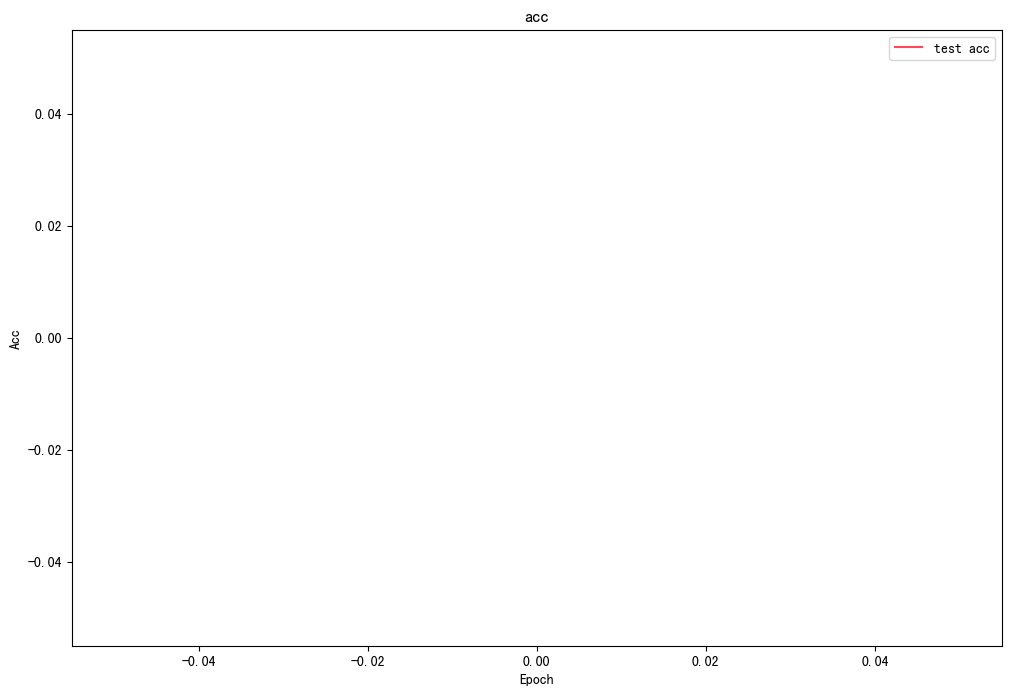

In [23]:
his = train()
plt.figure(figsize=(12, 8))
plt.plot(range(len(his)),
            his,
            c=np.array([255, 71, 90]) / 255.,
            label='test acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(loc=0)
plt.title('acc')
plt.savefig("../assets/acc.png")
plt.show()

In [ ]:
def sampling(src_nodes, sample_num, neighbor_table):
    """
    根据源节点一阶采样指定数量的邻居，有放回
    :param src_nodes: 源节点
    :param sample_num: 采用邻居节点数
    :param neighbor_table: 邻接矩阵
    :return: 返回所有源节点的采样邻居，二维列表，每个列表代表一个源节点的采样邻居
    """
    results = []
    for sid in src_nodes:
        # 从节点的邻居中进行有放回地进行采样
        neighbor_nodes = neighbor_table.getrow(sid).nonzero()   # 得到源节点的所有邻居，非零邻居
        res = np.random.choice(np.array(neighbor_nodes).flatten(), size=sample_num) # 从所有邻居中采样sample_num个数
        results.append(res)
        # print(res)
    return np.asarray(results).flatten()


def multihop_sampling(src_nodes, sample_nums, neighbor_table):
    """
    根据源节点进行多阶采样
    :param src_nodes: 源节点
    :param sample_nums: 采样邻居节点数
    :param neighbor_table:  邻接矩阵
    :return:
    """
    sampling_result = [src_nodes]
    # print('sampling_result',sampling_result)
    for k, hopk_num in enumerate(sample_nums):
        hopk_result = sampling(sampling_result[k], hopk_num, neighbor_table)
        sampling_result.append(hopk_result)
    return sampling_result


In [ ]:
# # 训练过程tensor逐步分析
# model.train()
# acc_list = []
# for e in range(EPOCHS):
#     for batch in range(NUM_BATCH_PER_EPOCH):
#         batch_src_index = np.random.choice(train_index,
#                                             size=(BTACH_SIZE, ))    # (16,),np.random.choice是指随机抽取数字组成size大小的数组
#         batch_src_label = torch.from_numpy(
#             train_label[batch_src_index]).long().to(DEVICE) # (16)
#         batch_sampling_result = multihop_sampling(batch_src_index,
#                                                     NUM_NEIGHBORS_LIST,
#                                                     data.adjacency_dict)    # list, length=3, item: array (16,)
#         batch_sampling_x = [
#             torch.from_numpy(x[idx]).float().to(DEVICE)
#             for idx in batch_sampling_result
#         ]   # list, length=3, item: array (16,1433)
#         # print(batch_src_index.shape)
#         # print(batch_src_label.shape)
#         # print(batch_sampling_result[0])
#         # print(batch_sampling_x[0])
#         batch_train_logits = model(batch_sampling_x)
#         loss = criterion(batch_train_logits, batch_src_label)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         print("Epoch {:03d} Batch {:03d} Loss: {:.4f}".format(
#             e, batch, loss.item()))
#     acc = test()
#     acc_list.append(acc)